# E2a: Küchentischversuch zum Laval-Rotor

Name: Tushar Sharma 
Datum:  25.12.2023

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:
Eine Analyse des Vergleichs der Vibrationen (Amplituden, Frequenzraum und Dauer) zwischen Handy und Waschmaschine.

# Erster Versuch
Hier werden Sie den ersten Gegenstand auswerten. Die Auswertung des zweiten Gegenstands kann das analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="Versuch_1.jpg" width="500">

- Beschreibung des Aufbaus: Ich habe den Beschleunigungssensor mit einem Klebeband an dieses Handy befestigt, um die Vibrationswerte zu ermitteln.
- Vorgangsbeschreibung: 
Ich lasse das Handy durch einen Alarm vibrieren und messe die Werte für 20 Sekunden, während das Handy ordnungsgemäß vibriert. Die gemessenen Werte sollen dann in einer HDF-Datei erscheinen.

## Versuchsauswertung

Die Vermessung des Haushaltsgegenstands wird in diesem Notebook ausgewertet, dazu werden die drei Funktionen ```get_vec_accel()```, ```interpolation()``` und ```my_fft()``` in ```functions/m_postprocessing.py``` verwendet. Die Ein- und Ausgangsgrößen der Funktionen sind in ```functions/m_postprocessing.py``` definiert, bitte berücksichtigen Sie die vordefinierten Datentypen.


Alle Codeblöcke, in denen Sie Änderungen vornehmen müssen, sind nachfolgend markiert.

In [1]:
import h5py
import numpy as np
import json
import os

%matplotlib inline
import matplotlib.pyplot as plt

from functions.m_operate import evaluate_metadata

from functions.m_postprocessing import get_vec_accel
from functions.m_postprocessing import interpolation
from functions.m_postprocessing import my_fft

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1a. Einlesen der Mess- und Metadaten

In [2]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folder = "measurement_data/data_20231225_145103_Tushar_Sharma_vibrationsalarm" # replace None by the relative path to the first object's folder
h5_file_name = "data_20231225_145103_Tushar_Sharma_vibrationsalarm.h5" # replace None by the filename of the hdf5-file
# ---------------------------------------------------------------------------------------------#1-end

In [3]:
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20231225_145103_Tushar_Sharma_vibrationsalarm\\1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20231225_145103_Tushar_Sharma_vibrationsalarm\\1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20231225_145103_Tushar_Sharma_vibrationsalarm\\1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "016b0fec-1384-64ac-884a-dc82a2c3295e": {
    "type": "probe",
    "name": "vibrationsalarm",
    "comm

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [4]:
#Creating a function where input is file path, group name, subgroup name and dataset name and output ist data values
def read_hdf_values(file_path, group_name, subgroup_name, dataset_name):
    with h5py.File(file_path, 'r') as file:
        # Access the dataset using the provided group and dataset names
        dataset = file[group_name][subgroup_name][dataset_name]
        # Read the values
        values = dataset[:]
    return values

file_path = "measurement_data/data_20231225_145103_Tushar_Sharma_vibrationsalarm/data_20231225_145103_Tushar_Sharma_vibrationsalarm.h5"
subgroup_name = "1ee847be-fddd-6ee4-892a-68c4555b0981"
group_name = "Rawdata"

dataset_name = "acceleration_x"
hdf_accelerator_x_data = read_hdf_values(file_path, group_name, subgroup_name, dataset_name) #reading out x values

dataset_name = "acceleration_y"
hdf_accelerator_y_data = read_hdf_values(file_path, group_name, subgroup_name, dataset_name) #reading out y values

dataset_name = "acceleration_z"
hdf_accelerator_z_data = read_hdf_values(file_path, group_name, subgroup_name, dataset_name) #reading out z values

dataset_name = "timestamp"
hdf_accelerator_time_data = read_hdf_values(file_path, group_name, subgroup_name, dataset_name) #reading out time values

# Convert to a one-dimensional NumPy array
accelerator_x = np.ravel(hdf_accelerator_x_data)

accelerator_y = np.ravel(hdf_accelerator_y_data)

accelerator_z = np.ravel(hdf_accelerator_z_data)


accelerator_time = np.ravel(hdf_accelerator_time_data)


#### 2. Betrag der Beschleunigung berechnen

Die Messdaten des Beschleunigungssensors sind vektorielle Werte (```acc_x, acc_y, acc_z```). Berechnen Sie für jeden Zeitpunkt in ```vec_time``` den Betrag des Beschleunigungsvektors. Verwenden Sie dazu die Funktion ```get_vec_accel()```. In den folgenden Aufgaben wird der Betrag der Beschleunigung weiterverwendet.

In [5]:
#calculating absolute values of numpy-arrays 
absolute_value = get_vec_accel(accelerator_x,accelerator_y,accelerator_z)

#### 3. Darstellung der Messdaten
Stellen Sie den Betrag der Beschleunigung über die Zeit und die zeitlichen Abstände zwischen den Messpunkten über die Zeit graphisch dar. Achten Sie dabei auf eine sinnvolle Achsenbeschriftung. 

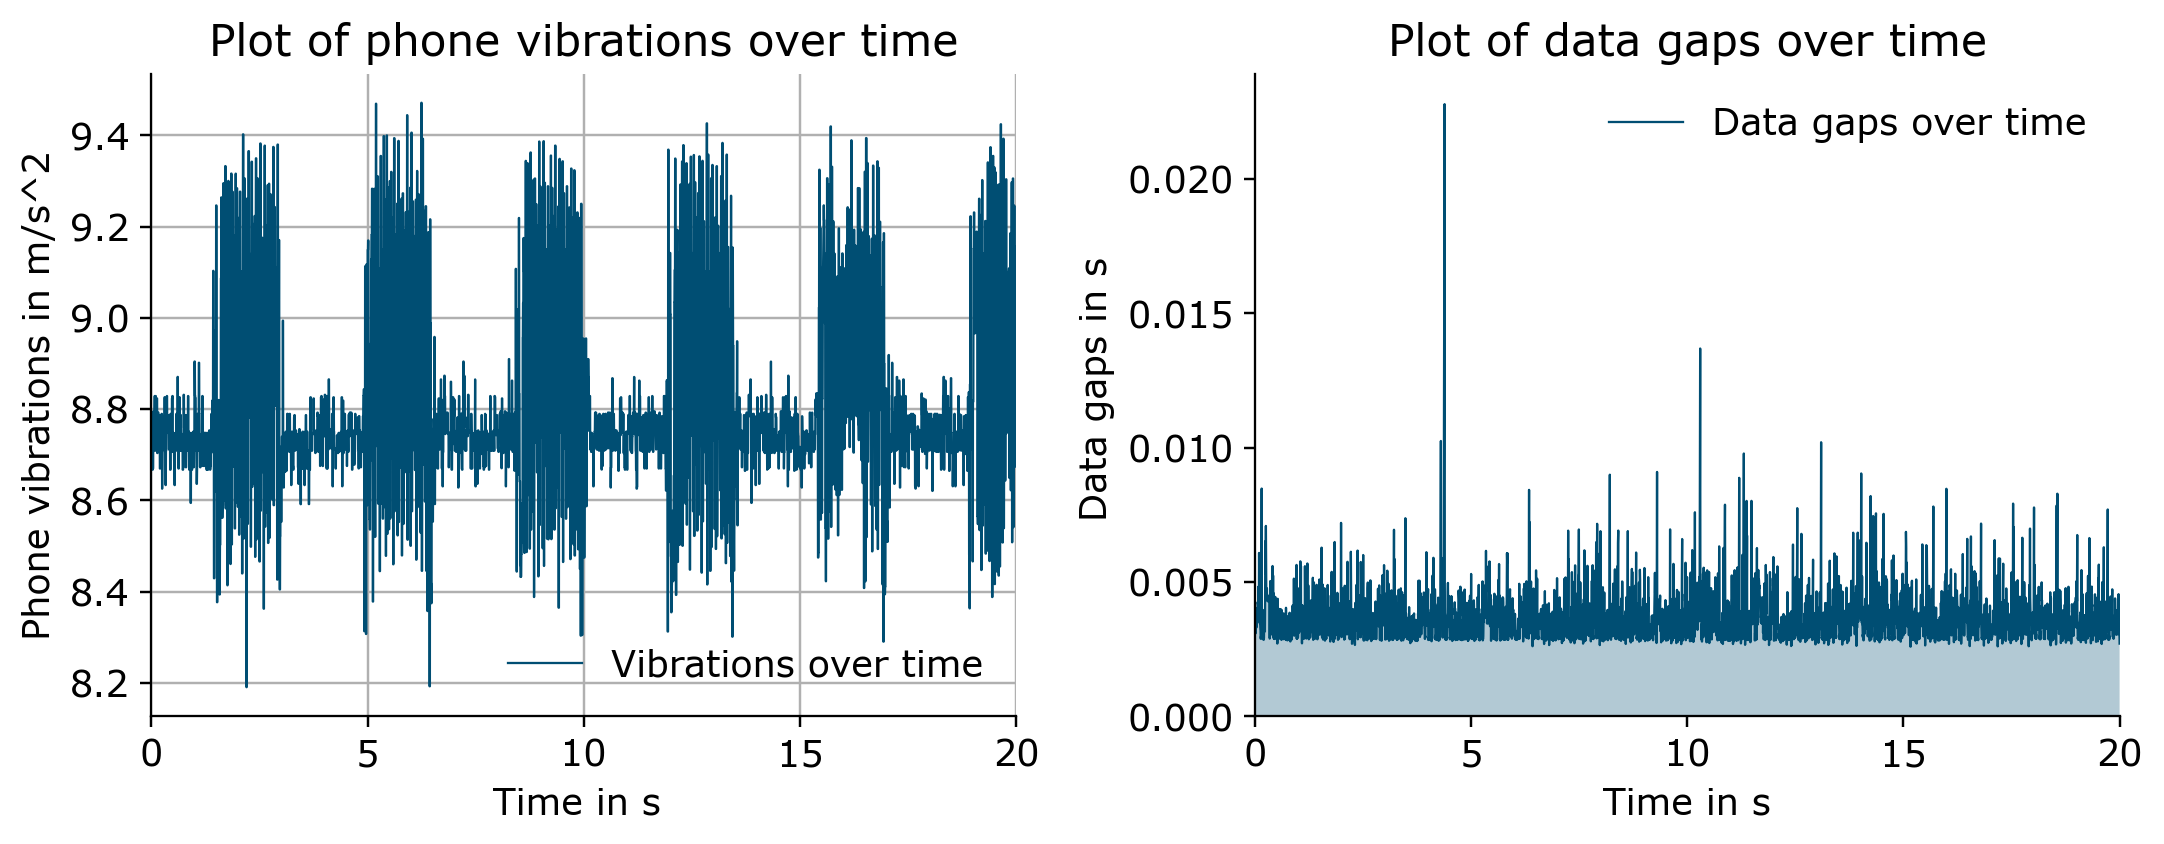

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4)) #plotting 2 diagramms as subplots

#first diagramm : Vibrations over time
axs[0].plot(accelerator_time, absolute_value, label='Vibrations over time')
axs[0].set_xlabel('Time in s ')
axs[0].set_xlim(0,20)
axs[0].set_ylabel('Phone vibrations in m/s^2')
axs[0].set_title('Plot of phone vibrations over time')
axs[0].legend()
axs[0].grid(True)

#second diagramm : time intervals between measurements over time
# Calculate the differences between consecutive values
time_interval = np.diff(accelerator_time)
axs[1].plot(accelerator_time[1:], time_interval, label='Data gaps over time')
axs[1].fill_between(accelerator_time[1:], time_interval, alpha=0.3)
axs[1].set_xlabel('Time in s')
axs[1].set_xlim(0,20)
axs[1].set_ylabel(' Data gaps in s')
axs[1].set_ylim(0,)
axs[1].set_title('Plot of data gaps over time')
axs[1].legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()



#### 4. Interpolation der Messwerte

Da es sich beim Pi nicht um ein Echtzeit-Messsystem handelt, variieren die Zeitabstände zwischen den Messwerten. Da für die FFT äquidistante Messwerte benötigt werden, ist eine Interpolation der Daten erforderlich.

In [7]:
# -------------------------------------------------------------------------------------------#4-start
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the
# acceleration.
accel_interp = interpolation(accelerator_time, absolute_value)
print(accel_interp)

(array([1.12557411e-03, 2.90350510e-03, 4.68143608e-03, ...,
       1.99975154e+01, 1.99992933e+01, 2.00010712e+01]), array([8.7534226 , 8.75189947, 8.7506975 , ..., 8.89890674, 8.89890674,
       8.89890674]))


#### 5 & 6. FFT durchführen und graphisch darstellen

Transformieren Sie die interpolierten Beträge der Beschleunigung mit der Funktion ```my_fft()``` in den Frequenzraum. Eine Skalierung der Amplitude der FFT ist nicht notwendig.
Stellen Sie die Amplitude des Signals als Funktion der Frequenz graphisch dar.

(array([9.91426594e+04, 2.30439083e+01, 1.28754042e+01, ...,
       6.52758918e-01, 7.19562762e-01, 1.65500016e+00]), array([0.00000000e+00, 4.99956914e-02, 9.99913829e-02, ...,
       2.81075777e+02, 2.81125773e+02, 2.81175769e+02]))


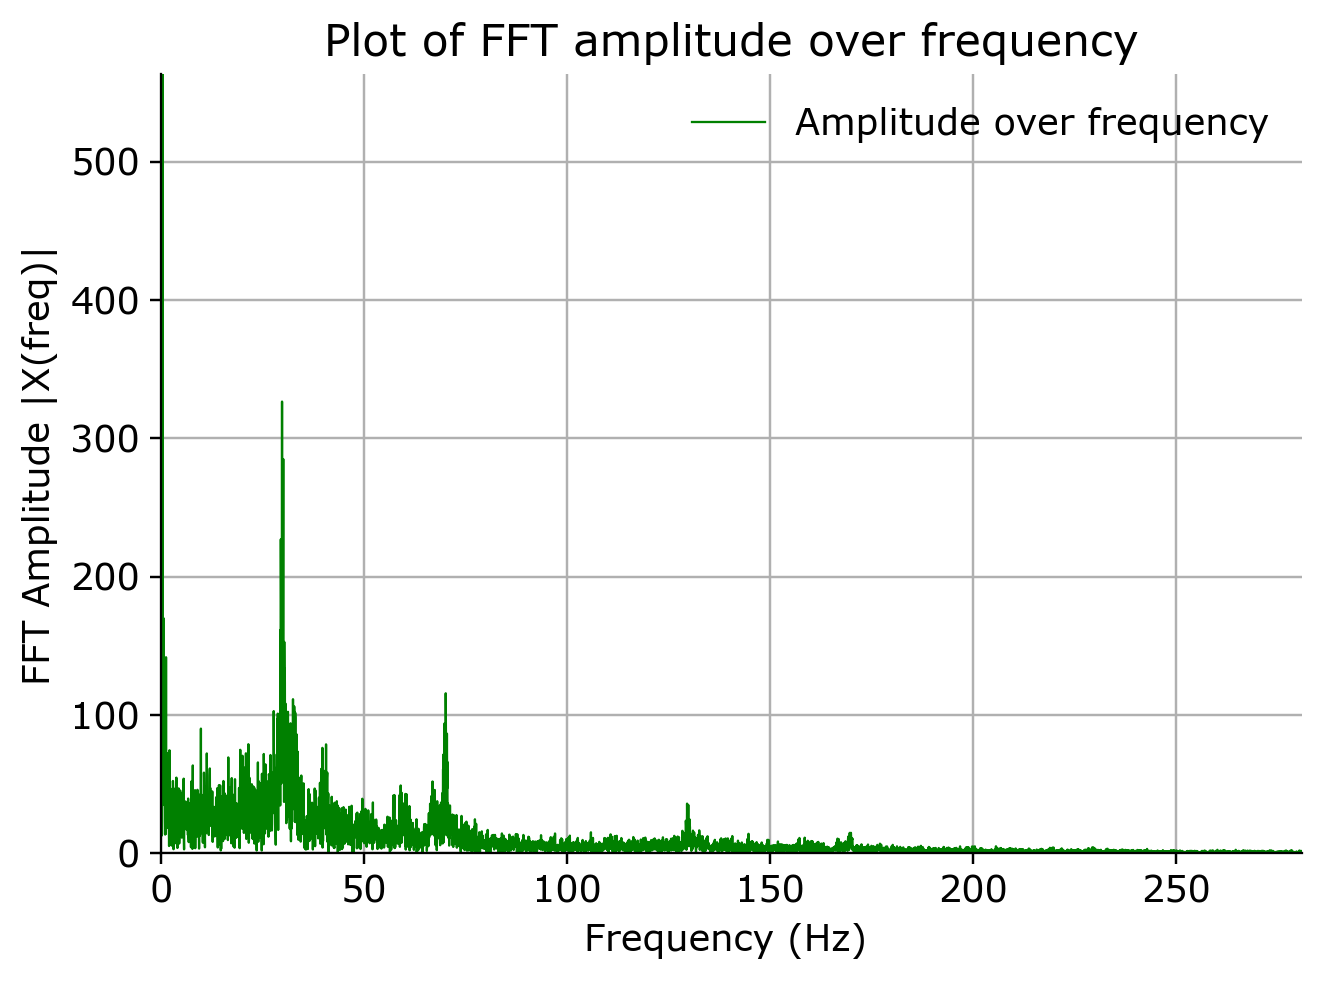

In [8]:
# -------------------------------------------------------------------------------------------#5-start
# TODO: Write my_fft() (in m_postprocessing) and plot results.
fft_accel = my_fft(accel_interp[1], accel_interp[0])
print(fft_accel)

#plot fft amplitude over frequency
plt.plot(fft_accel[1], fft_accel[0], label='Amplitude over frequency',color = 'green')
plt.xlabel('Frequency (Hz) ')
plt.xlim(0,max(fft_accel[1]))
plt.ylabel('FFT Amplitude |X(freq)|')
plt.ylim(0,max(fft_accel[0][1:]))
plt.title('Plot of FFT amplitude over frequency')
plt.legend()
plt.grid(True)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Zweiter Versuch
Hier werten Sie den zweiten Gegenstand aus.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="Versuch_2.jpg" width="500">

- Beschreibung des Aufbaus: Ich habe den Beschleunigungssensor mit einem Klebeband an diese Waschmaschine befestigt, um die Vibrationswerte zu ermitteln.
- Vorgangsbeschreibung:
Ich lasse die Waschmaschine spülen und messe die Vibrationswerte für 20 Sekunden ordnungsgemäß. Die gemessenen Werte sollen dann in einer HDF-Datei erscheinen.

## Versuchsauswertung

Führen Sie die obige Auswertung für den zweiten Gegenstand durch. Sie brauchen dafür nichts neu zu implementieren.

#### 1a. Einlesen der Mess- und Metadaten

In [9]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folder = "measurement_data/data_20231225_190709_Tushar_Sharma_waschemachine" # replace None by the relative path to the first object's folder
h5_file_name = "data_20231225_190709_Tushar_Sharma_waschemachine.h5" # replace None by the filename of the hdf5-file
# ---------------------------------------------------------------------------------------------#1-end

"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20231225_190709_Tushar_Sharma_waschemachine\\1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20231225_190709_Tushar_Sharma_waschemachine\\1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20231225_190709_Tushar_Sharma_waschemachine\\1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "016b1012-83af-681a-8877-6a43ebe5dc3b": {
    "type": "probe",
    "name": "waschemachine",
    "comment": ""

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [10]:
#Creating a function where input is file path, group name, subgroup name and dataset name and output ist data values
def read_hdf_values(file_path, group_name, subgroup_name, dataset_name):
    with h5py.File(file_path, 'r') as file:
        # Access the dataset using the provided group and dataset names
        dataset = file[group_name][subgroup_name][dataset_name]
        # Read the values
        values = dataset[:]
    return values

file_path = "measurement_data/data_20231225_190709_Tushar_Sharma_waschemachine/data_20231225_190709_Tushar_Sharma_waschemachine.h5"
subgroup_name = "1ee847be-fddd-6ee4-892a-68c4555b0981"
group_name = "Rawdata"

dataset_name = "acceleration_x"
hdf_accelerator_x_data = read_hdf_values(file_path, group_name, subgroup_name, dataset_name) #reading out x values

dataset_name = "acceleration_y"
hdf_accelerator_y_data = read_hdf_values(file_path, group_name, subgroup_name, dataset_name) #reading out y values

dataset_name = "acceleration_z"
hdf_accelerator_z_data = read_hdf_values(file_path, group_name, subgroup_name, dataset_name) #reading out z values

dataset_name = "timestamp"
hdf_accelerator_time_data = read_hdf_values(file_path, group_name, subgroup_name, dataset_name) #reading out time values

# Convert to a one-dimensional NumPy array
accelerator_x = np.ravel(hdf_accelerator_x_data)

accelerator_y = np.ravel(hdf_accelerator_y_data)

accelerator_z = np.ravel(hdf_accelerator_z_data)


accelerator_time = np.ravel(hdf_accelerator_time_data)


#### 2. Betrag der Beschleunigung berechnen


In [11]:
#calculating absolute values of numpy-arrays 
absolute_value = get_vec_accel(accelerator_x,accelerator_y,accelerator_z)

#### 3. Darstellung der Messdaten

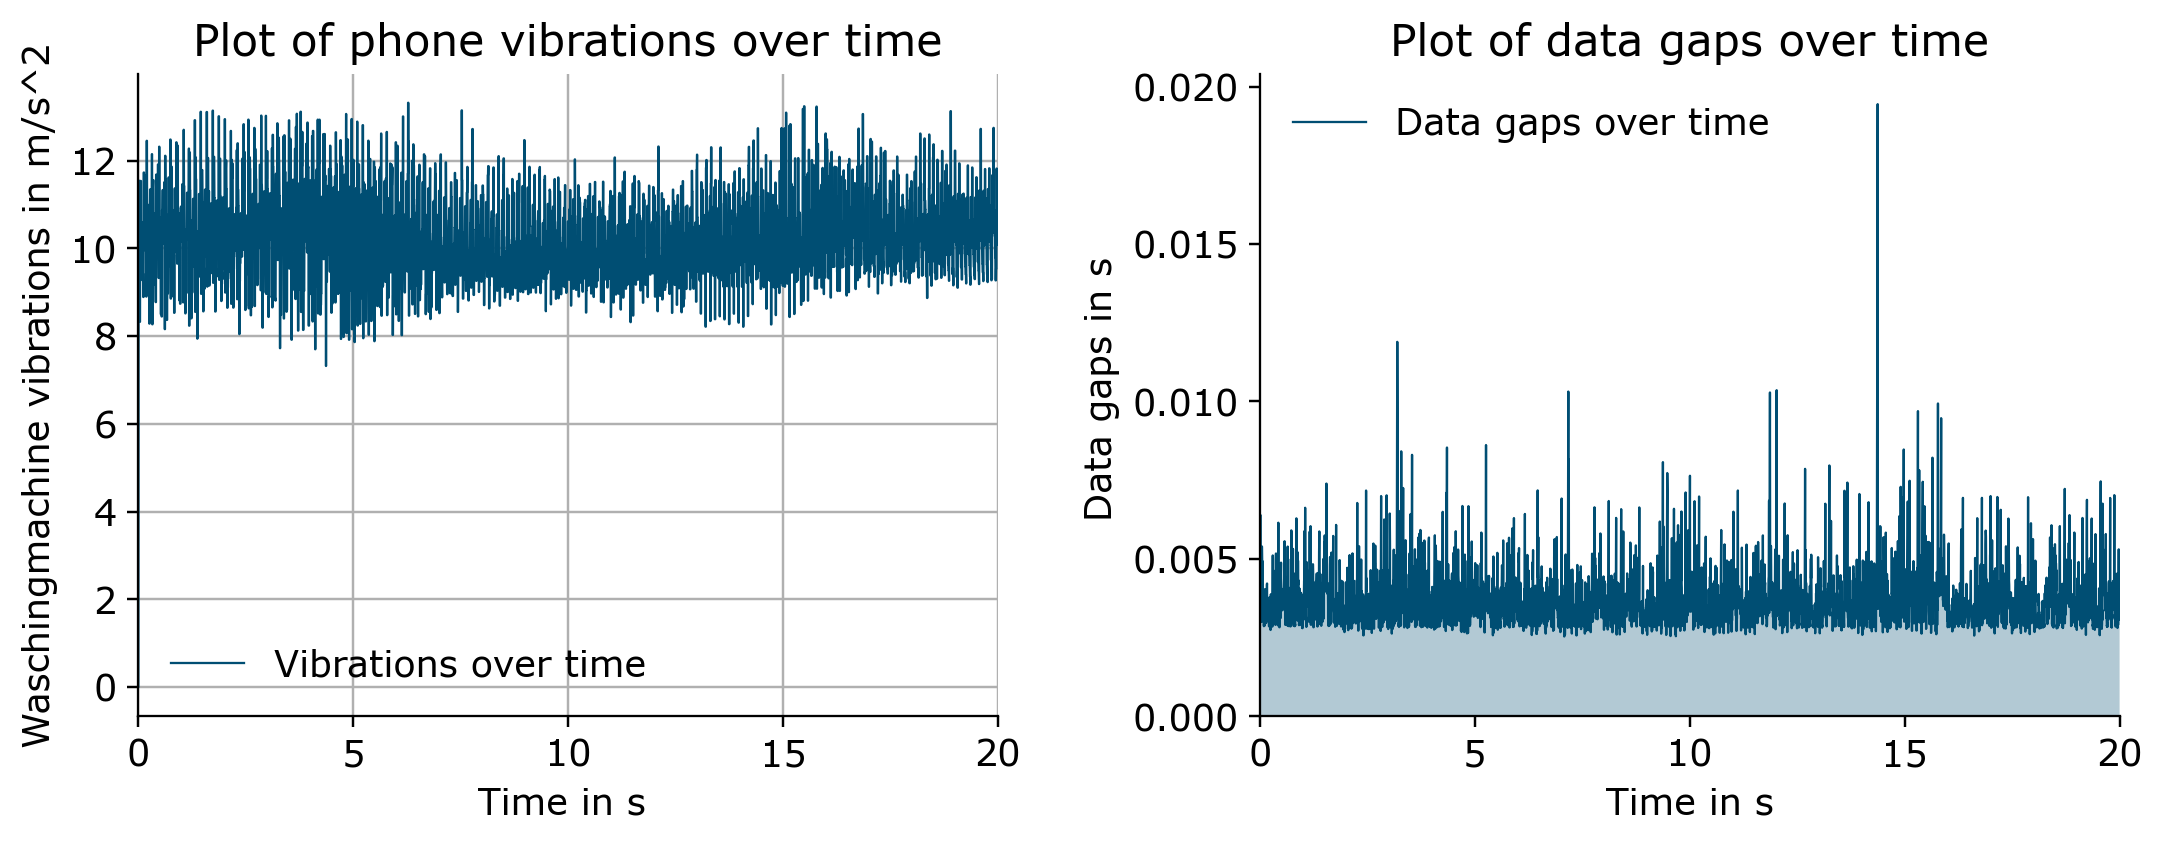

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4)) #plotting 2 diagramms as subplots

#first diagramm : Vibrations over time
axs[0].plot(accelerator_time, absolute_value, label='Vibrations over time')
axs[0].set_xlabel('Time in s ')
axs[0].set_xlim(0,20)
axs[0].set_ylabel('Waschingmachine vibrations in m/s^2')
axs[0].set_title('Plot of phone vibrations over time')
axs[0].legend()
axs[0].grid(True)

#second diagramm : time intervals between measurements over time
# Calculate the differences between consecutive values
time_interval = np.diff(accelerator_time)
axs[1].plot(accelerator_time[1:], time_interval, label='Data gaps over time')
axs[1].fill_between(accelerator_time[1:], time_interval, alpha=0.3)
axs[1].set_xlabel('Time in s')
axs[1].set_xlim(0,20)
axs[1].set_ylabel(' Data gaps in s')
axs[1].set_ylim(0,)
axs[1].set_title('Plot of data gaps over time')
axs[1].legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()



#### 4. Interpolation der Messwerte



In [13]:
# -------------------------------------------------------------------------------------------#4-start
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the
# acceleration.
accel_interp = interpolation(accelerator_time, absolute_value)
print(accel_interp)


(array([1.01590157e-03, 2.81948252e-03, 4.62306347e-03, ...,
       1.99973179e+01, 1.99991215e+01, 2.00009251e+01]), array([ 0.        ,  0.        ,  0.04378354, ..., 11.24282497,
       11.38957014, 11.38957014]))


#### 5 & 6. FFT durchführen und graphisch darstellen


(array([1.14191592e+05, 1.00835463e+03, 6.46369735e+02, ...,
       6.10535658e+00, 8.49521147e+00, 1.02501993e+01]), array([0.00000000e+00, 4.99957185e-02, 9.99914370e-02, ...,
       2.77076272e+02, 2.77126268e+02, 2.77176263e+02]))


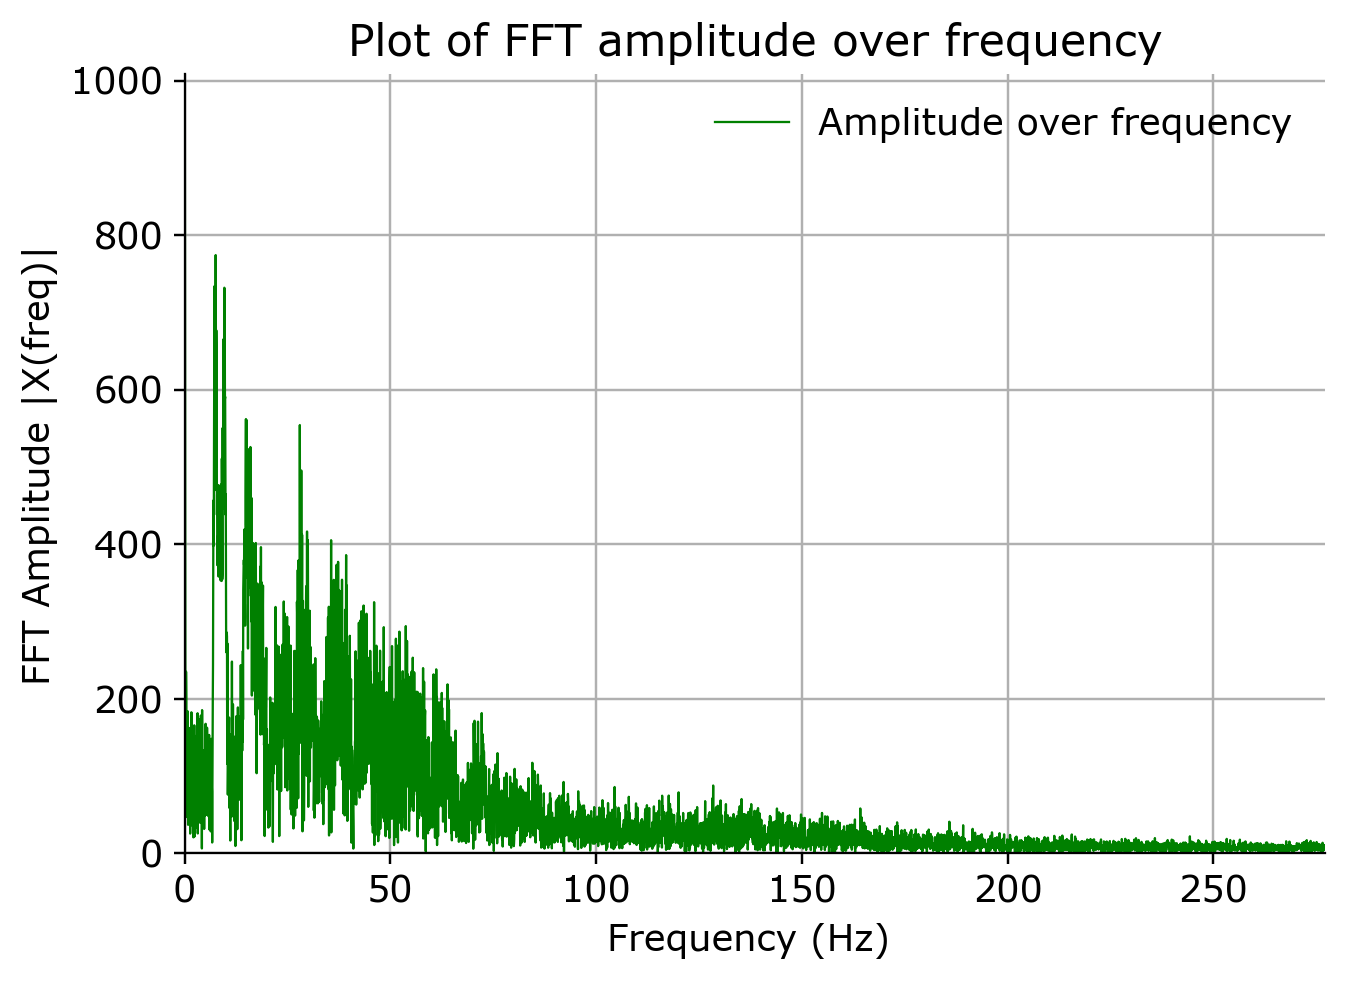

In [14]:
# -------------------------------------------------------------------------------------------#5-start
# TODO: Write my_fft() (in m_postprocessing) and plot results.
fft_accel = my_fft(accel_interp[1], accel_interp[0])
print(fft_accel)

#plot fft amplitude over frequency
plt.plot(fft_accel[1], fft_accel[0], label='Amplitude over frequency',color = 'green')
plt.xlabel('Frequency (Hz) ')
plt.xlim(0,max(fft_accel[1]))
plt.ylabel('FFT Amplitude |X(freq)|')
plt.ylim(0,max(fft_accel[0][1:]))
plt.title('Plot of FFT amplitude over frequency')
plt.legend()
plt.grid(True)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Der Vergleich der Vibrationsmessungen zwischen einem Handy und einer Waschmaschine offenbart faszinierende Unterschiede in der Natur der erzeugten Vibrationen. Während das Handy durch einen Alarm vibriert und präzise, kurze Impulse erzeugt , die von 8.8 m/s^2 zu 9.4 m/s^2 geht , zeigt die Waschmaschine eine kontinuierliche und oft komplexe Vibration während des Spülzyklus. Diese Unterschiede liefern Einblicke in die vielfältigen Anwendungen und Charakteristiken von Vibrationen in verschiedenen Kontexten, sei es in mobilen Geräten oder Haushaltsgeräten.



 Die gemessenen Vibrationen von Handy und Waschmaschine können durch verschiedene Faktoren beeinflusst werden, darunter die Position des Sensors, die Oberfläche, auf der das Gerät platziert ist, und Umgebungsbedingungen. Zudem repräsentieren die gemessenen Werte möglicherweise nicht vollständig die wahrgenommene Vibration durch den menschlichen Nutzer, da individuelle Empfindlichkeiten variieren können. Diese Überlegungen unterstreichen die Bedeutung einer kontextuellen Betrachtung und Vorsicht bei der Interpretation der Ergebnisse.





## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Durch dieses Experiment habe ich wertvolle Einblicke in die digitale Messung von Frequenzen, insbesondere bei der Analyse von Vibrationen von Objekten, gewonnen. Ich finde das Experiment durch bessere Codierung und Benutzung von bessere Sensor verbessert werden . Das Experiment war allegemein super Interessant .